# <a id='toc1_'></a>[1. Subscribe to the SDXL Model Package](#toc0_)

To subscribe to the SDXL Model Package:
1. Open the SDXL Model Package listing page: https://aws.amazon.com/marketplace/pp/prodview-pe7wqwehghdtm
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization accept the EULA, pricing, and support terms.

In [ ]:
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
! pip install protobuf==3.20

import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3

# <a id='toc2_'></a>[2: Create an endpoint and perform real-time inference](#toc0_)

In [3]:
# Choose your endpoint name
from sagemaker.utils import name_from_base
endpoint_name=name_from_base('sdxl-1-0-intro') # change this as desired

In [4]:
#endpoint_name="sdxl-1-0-intro-2023-09-10-18-23-56-477"

Once you have subscribed to Stability SDXL, get the Model Package ARN using the map below:


In [5]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad"
}


region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")
package_arn = model_package_map[region]  # TODO

role_arn = get_execution_role()
sagemaker_session = sagemaker.Session()

Create a deployable `ModelPackage`. For SDXL 1.0 use one of the following instances types: ml.g5.2xlarge, ml.p4d.24xlarge, p4de.24xlarge. Specify it as `instance_type` below.


In [6]:
model = ModelPackage(role=role_arn,model_package_arn=package_arn,sagemaker_session=sagemaker_session,predictor_cls=StabilityPredictor)

# Deploy the ModelPackage. This will take 5-10 minutes to run

instance_type="ml.g5.2xlarge" # valid instance types for this model are ml.g5.2xlarge, p4d.24xlarge, and p4de.24xlarge
deployed_model = model.deploy(initial_instance_count=1,instance_type=instance_type,endpoint_name=endpoint_name)

-------------!

If you have already deployed your model, you can also access it via your chosen `endpoint_name` and `sagemaker_session`:


In [7]:
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

We can call `predict` on our deployed model to return model outputs. For the full list of parameters, [see the Stability.ai SDK documentation.](https://api.stability.ai/docs#tag/v1generation)

## <a id='toc2_1_'></a>[Generate Images: Text to image](#toc0_)


In [8]:
prompt_1="Create a picture of a dog laying on grass"

In [13]:
image_path = "generated-images"

In [11]:
image_name_1 = "{}.png".format(prompt_1.replace(" ", "_"))
image_name_1

'Create_a_picture_of_a_dog_laying_on_grass.png'

In [12]:
output = deployed_model.predict(
    GenerationRequest(
        text_prompts=[TextPrompt(text=prompt_1)],
#        style_preset="photographic",
        width=1024,
        height=1024,
        seed=5,
    )
)

Output images are included in the response's `artifacts` as base64 encoded strings. Below is a helper function for accessing decoding these images:

In [14]:
def decode_and_show(model_response: GenerationResponse, image_name) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    image.save(image_path+"/"+image_name)
    display(image)

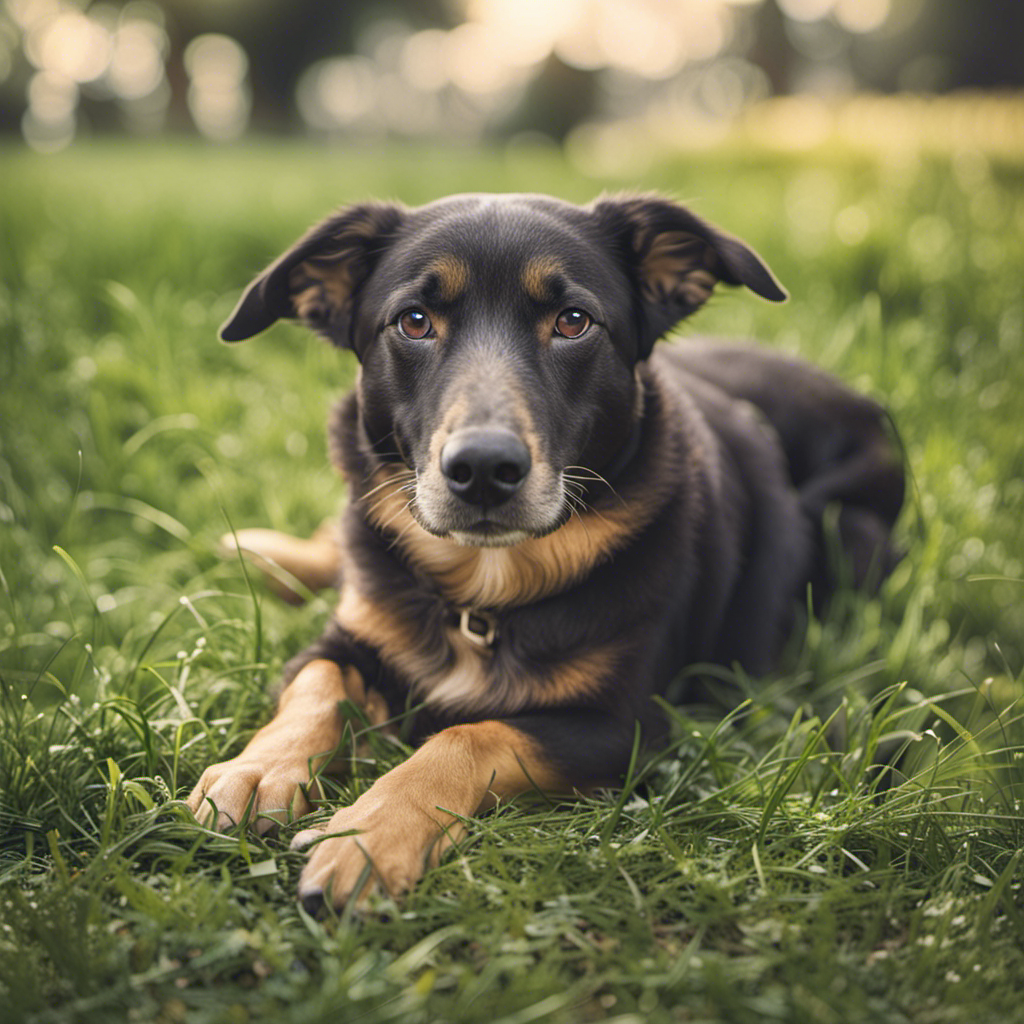

In [15]:
decode_and_show(output, image_name_1)

# <a id='toc3_'></a>[3: Delete the endpoint](#toc0_)

When you've finished working, you can delete the endpoint to release the EC2 instance(s) associated with it, and stop billing.

Get your list of Sagemaker endpoints using the AWS Sagemaker CLI like this:

In [ ]:
!aws sagemaker list-endpoints

# Delete an endpoint

In [ ]:
# deployed_model.sagemaker_session.delete_endpoint(endpoint_name)
# # Rerun the aws cli command above to confirm that its gone.